In [1]:
# general tools
import sys
from glob import glob
from datetime import datetime, timedelta

# data tools
import h5py
import numpy as np
import pandas as pd
from joblib import dump, load # <-- for loading sklearn models

# graph tools
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import cmaps
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/')
from namelist import *
import data_utils as du
import graph_utils as gu
import verif_utils as vu
import model_utils as mu
import train_utils as tu


In [2]:
%matplotlib inline

# Global settings

### File path and names

In [3]:
DATA_dir = PRISM_dir
RESULT_dir = save_dir
feature_name = 'NCEP_FNL_BC_2016_2018_4km.hdf'

# result files
PCT_PRED_name = 'OLD_results/PRISM_PRED_NCEP_PCT_BC_2016_2018.hdf'
BCH_meta = 'BCH_metadata.hdf'
BCH_obs = 'BCH_daily_2016_2019.hdf'

SAVE_dir = save_dir # place for backup temporaal files

### HDF keys

In [4]:
PCT_keys = ['UNET_A', 'XNET_A', 'PCT_REGRID'] # HR PRISM not exist
# calculation keys
PCT_keys_pred = ['PCT_REGRID', 'UNET_A', 'XNET_A']
# other keys
domains = ['train', 'trans']
seasons = ['djf', 'mam', 'jja', 'son']

In [5]:
N_all = 366 + 365 + 365 - 1
all_list = [datetime(2016, 1, 1, 0) + timedelta(days=x) for x in range(N_all)]
# time range for plotting (2018-2019)
N_pred = 365 - 1
pred_list = [datetime(2018, 1, 1, 0) + timedelta(days=x) for x in range(N_pred)]
# indices
ind_pred = du.dt_match(all_list, pred_list)
ind_sea = du.season_ind_sep(pred_list, key_format='{}')
ind_sea['annual'] = np.ones(N_pred).astype(bool) # add the "annual" key

# remove all-nans at the edge of the domain
pad = -15 # remove some edging grid points

# PCT histogram settings
thres = 24
pct_bins = np.linspace(thres, 72, 20)

In [6]:
with h5py.File(NCEP_dir+feature_name, 'r') as hdf_io:
    lon = hdf_io['lon'][...]
    lat = hdf_io['lat'][...]
    etopo_4km = hdf_io['etopo_BC'][...]
    land_mask = hdf_io['land_mask'][...]
    
wshed = np.load(RESULT_dir+'OLD_results/PRISM_BC_watershed.npy', allow_pickle=True)[()]['watershed']

### Graphic settings

In [7]:
# Cartopy map settings
scale_param = '10m' # 10m for publication quality
# US states and CAN-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

**watershed grouping**

In [8]:
wshed_se = np.zeros(wshed.shape)
wshed_se[wshed == 8] = 1
wshed_se[wshed == 10] = 2
wshed_se[wshed == 12] = 3
wshed_se[wshed == 14] = 4
wshed_se[wshed == 15] = 5
#wshed_se[wshed == 17] = 6
wshed_sw = np.zeros(wshed.shape)
wshed_sw[wshed == 11] = 1
wshed_sw[wshed == 1] = 2
wshed_sw[wshed == 3] = 3
wshed_sw[wshed == 4] = 4
wshed_sw[wshed == 6] = 5
wshed_sw[wshed == 7] = 6
wshed_sw[wshed == 11] = 7
wshed_sw[wshed == 13] = 8
wshed_sw[wshed == 18] = 9
wshed_sw[wshed == 19] = 10
wshed_sw[wshed == 16] = 11
wshed_sw[wshed == 2] = 12
wshed_sw[wshed == 5] = 13

wshed_n = np.zeros(wshed.shape)
wshed_n[wshed == 9] = 1

In [9]:
# precipitation cmap (from NCL)
cmap_pct = colors.LinearSegmentedColormap.from_list('temp_cmap', cmaps.prcp_1(np.arange(0, 17).tolist()))
# rain/no-rain color settings
cmap_prob = colors.LinearSegmentedColormap.from_list('temp_cmap', plt.cm.gist_stern_r(np.arange(0, 248).tolist()))
line_color1 = cmap_prob(32)
line_color2 = cmap_prob(248)

# histogram face colors
hist_colors = []
hist_colors.append(gu.xcolor('indian red'))
hist_colors.append(gu.xcolor('light salmon'))
hist_colors.append(gu.xcolor('deep sky blue'))
hist_colors.append(gu.xcolor('royal blue'))

In [10]:
fig_keys = {'dpi':250, 
            'orientation':'portrait', 
            'papertype':'a4',
            'bbox_inches':'tight', 
            'pad_inches':0, 
            'transparent':True}

# Data and calculations

## Gridded data

In [11]:
PCT = {}
with h5py.File(RESULT_dir+PCT_PRED_name, 'r') as hdf_io:
    for key in PCT_keys:
        temp = hdf_io[key][...]
        temp[:, land_mask] = np.nan
        PCT[key] = du.inv_log_trans(temp)

## BCH observations

In [12]:
with pd.HDFStore(BACKUP_dir+BCH_meta, 'r') as hdf_temp:
    metadata = hdf_temp['metadata']

stn_code = metadata['code'].values.tolist()
stn_lat = metadata['lat'].values
stn_lon = metadata['lon'].values
stn_elev = metadata['elev [m]'].values

with pd.HDFStore(BACKUP_dir+BCH_obs, 'r') as hdf_temp:
    code_2019 = hdf_temp.keys()
code_2019 = du.del_slash(code_2019)

pick_ind = du.str_search(stn_code, code_2019)

pick_ind = np.array(pick_ind)[np.array(pick_ind)<999]
stn_lat = stn_lat[pick_ind]
stn_lon = stn_lon[pick_ind]
code_pick = np.array(stn_code)[pick_ind]

item ARD not found.
item CCU not found.
item CPI not found.
item CRY not found.
item DWL not found.
duplicate items (will pick the last one):
1 --> GOL
56 --> GOL
duplicate items (will pick the last one):
0 --> ILL
64 --> ILL
item KAS not found.
duplicate items (will pick the last one):
3 --> KEY
66 --> KEY
item NDR not found.
item WSK not found.
item YLY not found.
item YOJ not found.
item YPE not found.


In [13]:
L = len(code_pick)
stn_obs = np.zeros([L, N_all])
with pd.HDFStore(BACKUP_dir+BCH_obs, 'r') as hdf_temp:
    for i, stn in enumerate(code_pick):
        stn_obs[i, ...] = hdf_temp[stn]['precip'].values
    
stn_obs[stn_obs>100] = np.nan

/glade/work/ksha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


In [14]:
stn_indx, stn_indy = du.grid_search(lon, lat, stn_lon, stn_lat)

In [15]:
flag_se = wshed_se[stn_indx, stn_indy]
flag_se = flag_se > 0
flag_sw = wshed_sw[stn_indx, stn_indy]
flag_sw = flag_sw > 0
flag_n = wshed_n[stn_indx, stn_indy]
flag_n = flag_n > 0

region_flag = {}
region_flag['SE'] = wshed_se > 0
region_flag['SW'] = wshed_sw > 0
region_flag['N'] = wshed_n > 0

stn_flag = {}
stn_flag['SE'] = flag_se
stn_flag['SW'] = flag_sw
stn_flag['N'] = flag_n

In [16]:
thres = 0
pct_bins = {}
pct_bins['SW'] = np.arange(0, 42, 2)
pct_bins['SE'] = np.arange(0, 18)
pct_bins['N'] = np.arange(0, 10.5, 0.5)

In [18]:
HIST = {}
regions = ['SE', 'SW', 'N']
models  = ['PCT_REGRID', 'UNET_A', 'XNET_A']

for region in regions:
    grid_flag = region_flag[region]
    obs_flag = stn_flag[region]
    true_temp = np.nanmean(stn_obs[obs_flag, :], axis=0)
    pick_flag = ~np.isnan(true_temp)
    true_temp = true_temp[pick_flag]
    temp_hist, _ = np.histogram(true_temp, pct_bins[region])
    HIST['TRUE_{}'.format(region)] = temp_hist
    HIST['TRUE_{}_param'.format(region)] = [np.std(true_temp), np.percentile(true_temp, 99)]
    
    for j, model in enumerate(PCT_keys_pred):
        f = 0.8
        grid_temp = np.nanmean(f*PCT[model][:, grid_flag], axis=1)[pick_flag]
        temp_hist, _ = np.histogram(grid_temp, pct_bins[region])
        HIST['{}_{}'.format(model, region)] = temp_hist
        HIST['{}_{}_param'.format(model, region)] = [np.std(grid_temp), np.percentile(grid_temp, 99)]


/glade/work/ksha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


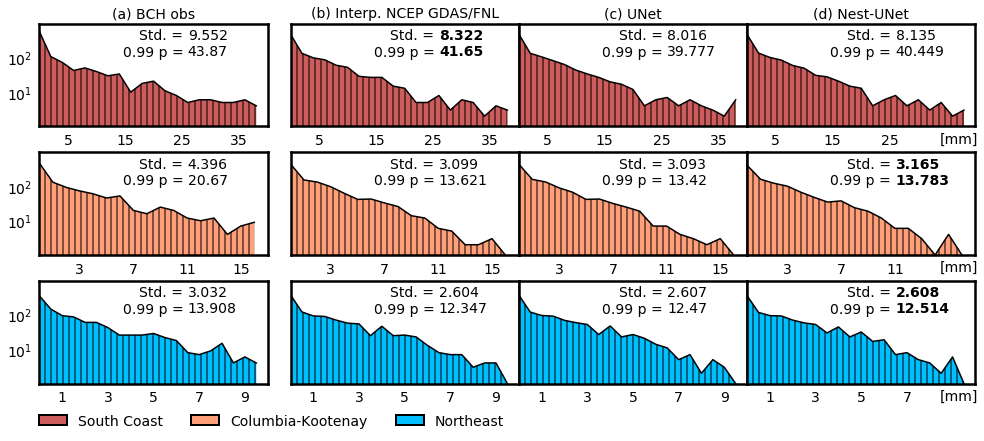

In [22]:
fig = plt.figure(figsize=(13, 5))
gs = gridspec.GridSpec(3, 5, width_ratios=[1, 0.1, 1, 1, 1])
plt.subplots_adjust(0, 0, 1, 1, hspace=0.25, wspace=0)

AX1 = []; AX2 = []; AX3 = []
for i in [0, 2, 3, 4]:
    AX1.append(plt.subplot(gs[0, i]))
    AX2.append(plt.subplot(gs[1, i]))
    AX3.append(plt.subplot(gs[2, i]))

AX = [AX1, AX2, AX3]

# ===== Macros ===== #

titles  = ['(a) BCH obs', '(b) Interp. NCEP GDAS/FNL', '(c) UNet', '(d) Nest-UNet']
ylabels = ['South Coast', 'Columbia-Kootenay', 'Northeast']

regions = ['SW', 'SE', 'N']
models  = ['TRUE', 'PCT_REGRID', 'UNET_A', 'XNET_A']

FW_std = [['normal', 'bold', 'normal', 'normal'], 
          ['normal', 'normal', 'normal', 'bold'], 
          ['normal', 'normal', 'normal', 'bold']]

FW_99p = [['normal', 'bold', 'normal', 'normal'], 
          ['normal', 'normal', 'normal', 'bold'], 
          ['normal', 'normal', 'normal', 'bold']]

# ===== Background features ===== #

YLIM = [1e3, 1e3, 1e3]
XLIM = [[0, pct_bins['SW'][-1]], 
        [0, pct_bins['SE'][-1]], 
        [0, pct_bins['N'][-1]]]
YTICKS = [[1e1, 1e2], [1e1, 1e2], [1e1, 1e2]]
XTICKS = [[5, 15, 25, 35], 
          [3, 7, 11, 15], 
          [1, 3, 5, 7, 9]]

for i in range(3):
    for j in range(4):
        ax = AX[i][j]
        ax = gu.ax_decorate_box(ax)
        ax.set_yscale('log')
        ax.tick_params(labelbottom=True)
        ax.set_ylim([1, YLIM[i]])
        ax.set_yticks(YTICKS[i])
        ax.set_xlim(XLIM[i])
        if j == 3:
            ax.set_xticks(XTICKS[i][:-1])
        else:
            ax.set_xticks(XTICKS[i])
        
    AX[i][0].tick_params(labelleft=True)

for i in range(4):
    AX[-1][i].tick_params(labelbottom=True)
    AX[0][i].set_title(titles[i], fontsize=14)
for i in range(3):
    AX[i][-1].yaxis.set_label_position("right")
    AX[i][-1].text(1.01, -0.16, '[mm]', fontsize=14, ha='right', transform=AX[i][-1].transAxes)

# ===== Content ===== #

for i, region in enumerate(regions):
    for j, model in enumerate(models):
        AX[i][j].fill_between(pct_bins[region][:-1], np.zeros([len(pct_bins[region][:-1])]), 
                              HIST['{}_{}'.format(model, region)], facecolor=hist_colors[i], hatch='||')
        AX[i][j].plot(pct_bins[region][:-1], HIST['{}_{}'.format(model, region)], 'k-', lw=1.5)
        param = np.round(HIST['{}_{}_param'.format(model, region)], 3)
        AX[i][j].text(0.65, 0.95, 'Std. = \n0.99 p = '.format(param[0]),
                     ha='right', va='top', fontsize=14, transform=AX[i][j].transAxes)
        AX[i][j].text(0.65, 0.95, '{}'.format(param[0]),
                     ha='left', va='top', fontsize=14, fontweight=FW_std[i][j], transform=AX[i][j].transAxes)
        AX[i][j].text(0.65, 0.795, '{}'.format(param[1]),
                     ha='left', va='top', fontsize=14, fontweight=FW_99p[i][j], transform=AX[i][j].transAxes)

# ===== Floating axis objects ===== #
# legend
legend_box = []
for i in range(3):
    legend_box.append(patches.Patch(facecolor=hist_colors[i], edgecolor='k', linewidth=2.0, label=ylabels[i]))

ax_lg = fig.add_axes([0, -0.1, 0.51, 0.05])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=legend_box, bbox_to_anchor=(1, 1), ncol=5, prop={'size':14});
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)

# # Save
# fig.savefig(fig_dir+'PCT_FNL_BC_distrib_verif.png', format='png', **fig_keys)